# Auto-encoder vs PCA avec des données sur les élections

In [1]:
import numpy as np
from turtle import * 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas

In [3]:
elections=pandas.read_excel("dataElections.xlsx", encoding='utf8')

In [4]:
elections.head(2)

,Code.du.département,Libellé.du.département,Code.de.la.circonscription,Libellé.de.la.circonscription,Code.de.la.commune,Libellé.de.la.commune,Code.du.b.vote,Inscrits,Abstentions,X..Abs.Ins,...,Voix10,X..Voix.Ins10,X..Voix.Exp10,N.Panneau11,Sexe11,Nom11,Prénom11,Voix11,X..Voix.Ins11,X..Voix.Exp11
0,1,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,1,598,92,15.38,...,6,1.00,1.21,11,M,FILLON,François,110,18.39,22.22
1,1,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,1,209,25,11.96,...,1,0.48,0.57,11,M,FILLON,François,34,16.27,19.32


In [5]:
print(elections.shape)

(69242, 98)


### 1) Principal Component Analysis (PCA)

In [6]:
from sklearn.decomposition import PCA

##### 1.1 Feature sélection

In [8]:
candidats=elections[["X..Voix.Ins1", "X..Voix.Ins2", "X..Voix.Ins3", "X..Voix.Ins4", "X..Voix.Ins5", "X..Voix.Ins6", "X..Voix.Ins7", "X..Voix.Ins8", "X..Voix.Ins9", "X..Voix.Ins10", "X..Voix.Ins11"]]
candidats.columns=["Nicolas DUPONT-AIGNAN", "Marine LE PEN", "Emmanuel MACRON", "Benoît HAMON", "Nathalie ARTHAUD", "Philippe POUTOU", "Jacques CHEMINADE", "Jean LASALLE", "Jean-Luc MELENCHON", "François ASSELINEAU", "François FILLON"]

##### 1.2 PCA with 5 axis

In [9]:
pca = PCA(n_components=5)
pca.fit(candidats)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
# Estimation, calcul des composantes principales
C = pca.fit(candidats).transform(candidats)

##### 1.3 Display PCA output

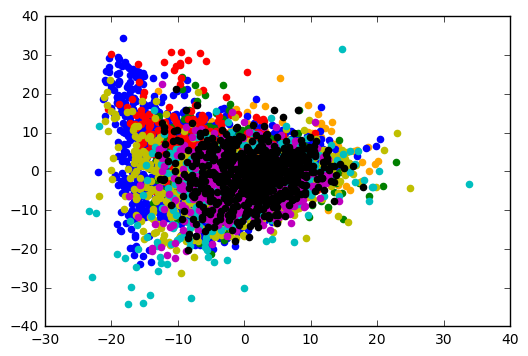

In [57]:
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Ain').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Ain').reshape(elections.shape[0]),1], label='Ain', color="orange")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Rhône').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Rhône').reshape(elections.shape[0]),1], label='Rhône', color="b")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Savoie').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Savoie').reshape(elections.shape[0]),1], label='Savoie', color="g")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Haute-Savoie').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Haute-Savoie').reshape(elections.shape[0]),1], label='Haute-Savoie', color="r")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Isère').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Isère').reshape(elections.shape[0]),1], label='Isère', color="y")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Drôme').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Drôme').reshape(elections.shape[0]),1], label='Drôme', color="c")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Ardèche').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Ardèche').reshape(elections.shape[0]),1], label='Ardèche', color="m")
plt.scatter(C[np.array(elections[["Libellé.du.département"]]=='Loire').reshape(elections.shape[0]),0], C[np.array(elections[["Libellé.du.département"]]=='Loire').reshape(elections.shape[0]),1], label='Loire', color="k")

### 2) Non linear deep auto-encoder with keras

In [58]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


##### 2.1 Build an non linear deep auto-encoder architecture (like the Hinton's article about dimensionality reduction)

In [60]:
# Size of our encoded representations (compression of input image from 784 floats to 2 floats)
encoding_dim = 2 

# Input placeholder :
input_img = Input(shape=(11,))

# Encoded representation of the input (="encoded") :
encoded = Dense(5, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Lossy reconstruction of the input (="decoded") :
decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(11, activation='relu')(decoded)

# Model maps an input to its encoded representation :
encoder = Model(input_img, encoded)
# Model maps an input to its reconstruction :
autoencoder = Model(input_img, decoded)

# Placeholder for an encoded (2-dimensional) input :
encoded_input = Input(shape=(5,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
# Pass optimizer (adadelta) with a 'mean squared error" loss
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [110]:
permutation=np.random.permutation(candidats.shape[0])
nb_apprentissage=(2*candidats.shape[0])//3
x_train=np.array(candidats.ix[permutation[0:nb_apprentissage],])
x_test=np.array(candidats.ix[permutation[nb_apprentissage::],])
y_train=np.array(elections.ix[permutation[0:nb_apprentissage],"Libellé.du.département"])
y_test=np.array(elections.ix[permutation[nb_apprentissage::],"Libellé.du.département"])

##### 3.2 Trained an auto-encoder and predict

In [116]:
autoencoder.fit(x_train, x_train, nb_epoch=50, batch_size=256, shuffle=True, validation_data=(x_test,x_test))
encoded_imgs=encoder.predict(np.array(candidats))
decoded_imgs=decoder.predict(encoded_imgs)

Train on 46161 samples, validate on 23081 samples
Epoch 1/50
46161/46161 [==============================] - 0s - loss: 30.7981 - val_loss: 30.4623 6656/46161 [===>..........................] - ETA: 0s - loss: 31.0852
Epoch 2/50
46161/46161 [==============================] - 0s - loss: 30.7926 - val_loss: 30.4543

ValueError: Error when checking : expected input_4 to have shape (None, 5) but got array with shape (69242, 2)

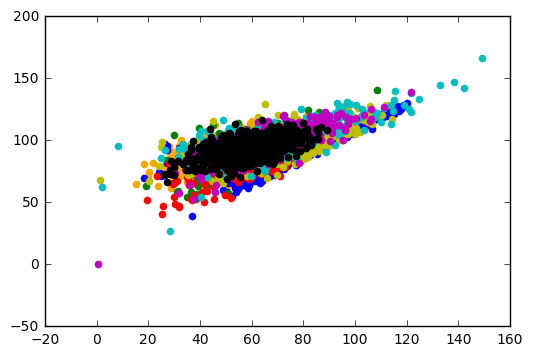

In [117]:
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Ain').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Ain').reshape(elections.shape[0]),1], label='Ain', color="orange")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Rhône').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Rhône').reshape(elections.shape[0]),1], label='Rhône', color="b")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Savoie').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Savoie').reshape(elections.shape[0]),1], label='Savoie', color="g")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Haute-Savoie').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Haute-Savoie').reshape(elections.shape[0]),1], label='Haute-Savoie', color="r")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Isère').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Isère').reshape(elections.shape[0]),1], label='Isère', color="y")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Drôme').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Drôme').reshape(elections.shape[0]),1], label='Drôme', color="c")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Ardèche').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Ardèche').reshape(elections.shape[0]),1], label='Ardèche', color="m")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Loire').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Loire').reshape(elections.shape[0]),1], label='Loire', color="k")

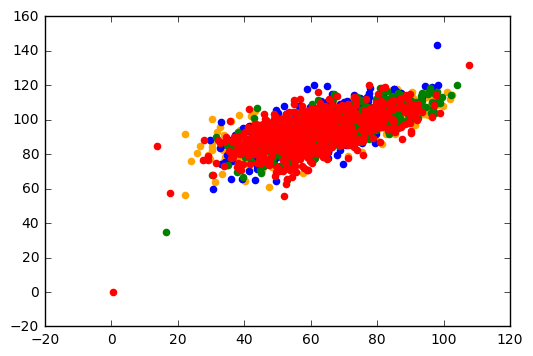

In [120]:
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Vienne').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Vienne').reshape(elections.shape[0]),1], label='Vienne', color="orange")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Charente').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Charente').reshape(elections.shape[0]),1], label='Charente', color="b")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Deux-Sèvres').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Deux-Sèvres').reshape(elections.shape[0]),1], label='Deux-Sèvres', color="g")
plt.scatter(encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Charente-Maritime').reshape(elections.shape[0]),0], encoded_imgs[np.array(elections[["Libellé.du.département"]]=='Charente-Maritime').reshape(elections.shape[0]),1], label='Charente-Maritime', color="r")